In [1]:
%matplotlib inline

In [3]:
import json
import pigeo.pigeo

import pandas as pd
import matplotlib.pyplot as plt
import country_converter as coco

In [4]:
def json_to_tweet(json_str):
    tweet = None
    try:
        tweet = json.loads(json_str)
    except:
        pass
    return tweet

def tweet_to_user_tup(tweet):
    user = tweet["user"]
    return (user["id"], [user["location"]])

def partition_mapper(user_tuples):
    pigeo.pigeo.load_model()
    
    def predict_country(location_str):
        r = pigeo.pigeo.geo(location_str, False)
        return (r["country_code"], list(r["label_distribution"].values())[0])
    
    predicted_locs = []
    for user_tup in user_tuples:
        user_id = user_tup[0]
        locations = {loc.replace("@", " ") for loc in user_tup[1] if loc is not None}
        
        pred_locs = [predict_country(loc) for loc in locations]
        if ( len(pred_locs) > 0 ):
            best_prediction = sorted(pred_locs, key=lambda x: x[1], reverse=True)[0]
            predicted_locs.append((user_id, best_prediction))
            
    return iter(predicted_locs)

Reading data...
Predicting Location...


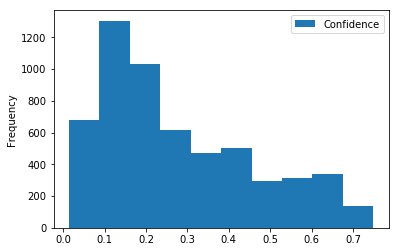

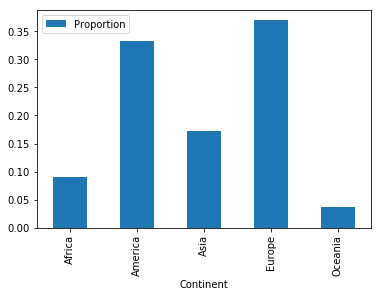

Reading data...
Predicting Location...


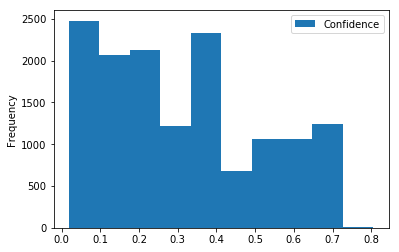

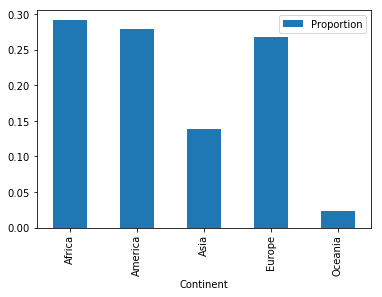

In [27]:
df_map = {}
for year in ["2017", "2018"]:

    print("Reading data...")
    rdd = sc.textFile("wri/%s_community_filtered" % year)
    users = rdd.map(json_to_tweet)\
        .filter(lambda tweet: tweet is not None)\
        .map(tweet_to_user_tup)\
        .reduceByKey(lambda l,r: l+r)

    print("Predicting Location...")
    user_locations = users.repartition(4).mapPartitions(partition_mapper).collect()
    countries = [x[1] for x in user_locations]

    country_df = pd.DataFrame(countries, columns=["Country", "Confidence"])
    country_df.groupby("Country").count().to_csv("%s_countries.csv" % year)

    country_df.plot.hist("Confidence")
    plt.show()

    country_freq_df = pd.read_csv("%s_countries.csv" % year)
    country_freq_df.sort_values(by="Confidence", ascending=False)

    country_freq_df["Continent"] = country_freq_df["Country"]\
        .apply(lambda c: coco.convert(names=c, to="continent"))

    normed = country_freq_df.groupby("Continent").sum() / country_freq_df["Confidence"].sum()

    normed.rename(columns={"Confidence": "Proportion"}).plot.bar()
    plt.show()
    
    df_map[year] = normed

In [35]:
merged = df_map["2017"]\
    .join(df_map["2018"], lsuffix="_2017", rsuffix="_2018")\
    .rename(columns={"Confidence_2017": "GLF Bonn 2017", "Confidence_2018": "GLF Nairobi 2018"})

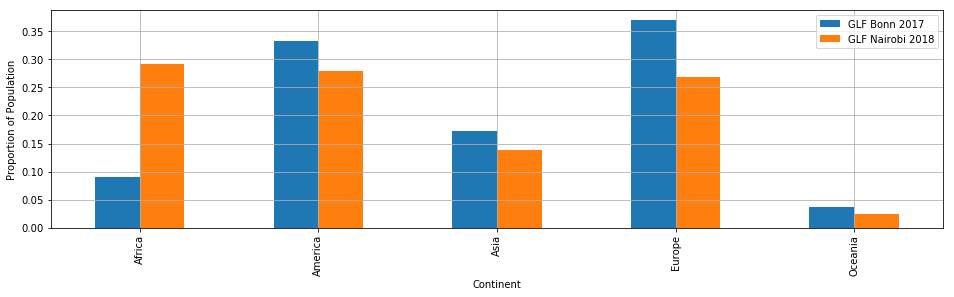

In [39]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(1,1,1)

merged.plot.bar(ax=ax)

ax.set_ylabel("Proportion of Population")

plt.grid()
plt.show()